In [1]:
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id

dl = DataSet(sample_in,sample_out,data_mode='sparse',data_ondisk=False)
dl.config = args
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/simdata


In [18]:
model = np.load(sample_out+'_fnmf.npz')

In [19]:
beta = model['beta']
theta = model['theta']
uu = beta.sum(0)
beta = beta/uu
prop = theta * uu
zz = prop.T.sum(0).reshape(theta.shape[0],1)
prop = prop/zz

df_beta = pd.DataFrame(beta.T)
df_beta.columns = dl.cols
df_theta = pd.DataFrame(theta)
df_theta.index = dl.rows

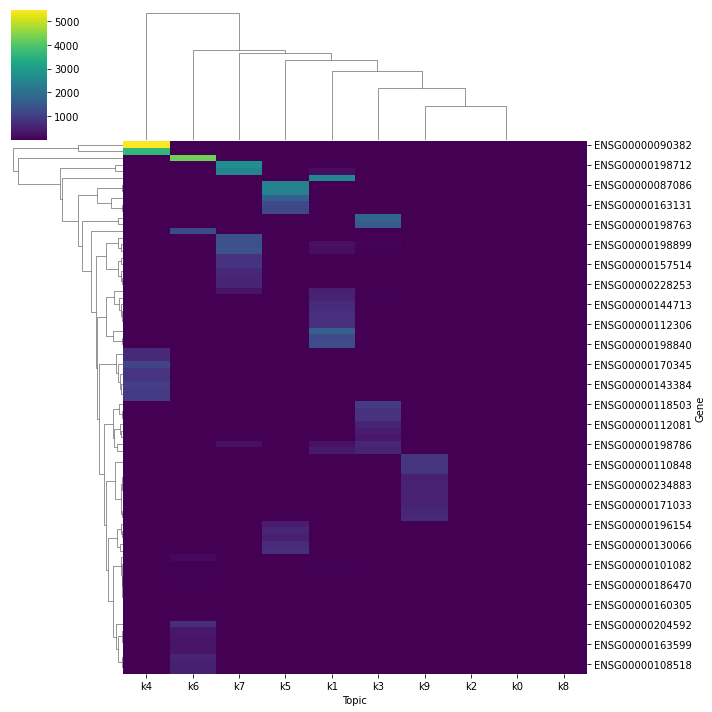

In [20]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

In [40]:
dl.mtx.shape

(10000, 57773)

In [47]:
from sklearn.preprocessing import StandardScaler

dl.load_data()

scaler = StandardScaler()
scaled = scaler.fit_transform(model['beta_log'])
t1 = pd.DataFrame(np.dot(dl.mtx, scaled))

ysum = np.array(dl.mtx.T.sum(0)).T
corr = t1/ysum


df_theta = pd.DataFrame(corr)
df_theta.index = dl.rows
df_theta.to_csv(sample_out+'_theta.csv.gz')

In [48]:
import umap
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.9,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap


# df_umap= pd.DataFrame()
# df_umap['cell'] = dl.rows
# df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

# df_umap2 = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap2.columns = ['cell','umap1','umap2']
# df_umap = pd.merge(df_umap,df_umap2,on='cell')
# df_umap

,cell,topic_bulk,umap1,umap2
0,"0_Monocyte,classical",4,12.814855,16.185745
1,"1_Monocyte,classical",4,13.882455,18.007208
2,"2_Monocyte,classical",4,14.909540,16.493996
3,"3_Monocyte,classical",4,14.234731,17.636045
4,"4_Monocyte,classical",4,15.151195,17.122532
...,...,...,...,...
9995,"995_Tcell,CD4,TH1/17",1,6.857012,8.757366
9996,"996_Tcell,CD4,TH1/17",1,6.561380,7.200580
9997,"997_Tcell,CD4,TH1/17",1,7.186441,7.272185
9998,"998_Tcell,CD4,TH1/17",1,5.197474,7.772921


Text(0, 0.5, 'UMAP2')

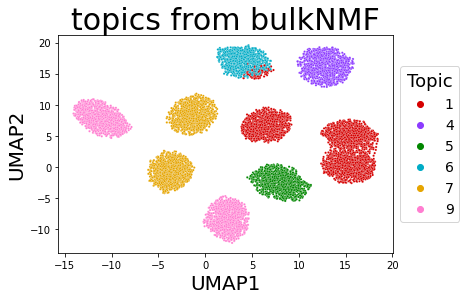

In [56]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

Text(0, 0.5, 'UMAP2')

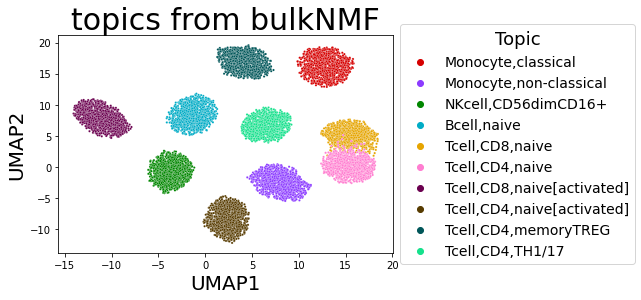

In [50]:
df_umap['cell_type'] = [x.split('_')[1] for x in df_umap['cell']]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

In [51]:
bulk_data = '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/resources/dice/mean_tpm_merged.csv.gz'
df_dice = pd.read_csv(bulk_data,compression='zip')

# remove non naive T cells
df_dice = df_dice[['gene', 
'Monocyte, classical',
'Monocyte, non-classical',
'NK cell, CD56dim CD16+',
'B cell, naive', 
'T cell, CD8, naive',
'T cell, CD4, naive',
'T cell, CD8, naive [activated]',
'T cell, CD4, naive [activated]',
'T cell, CD4, memory TREG', 
'T cell, CD4, TH1/17',
]]
df_dice = df_dice.set_index('gene').T

Text(218.45454545454544, 0.5, 'bulk')

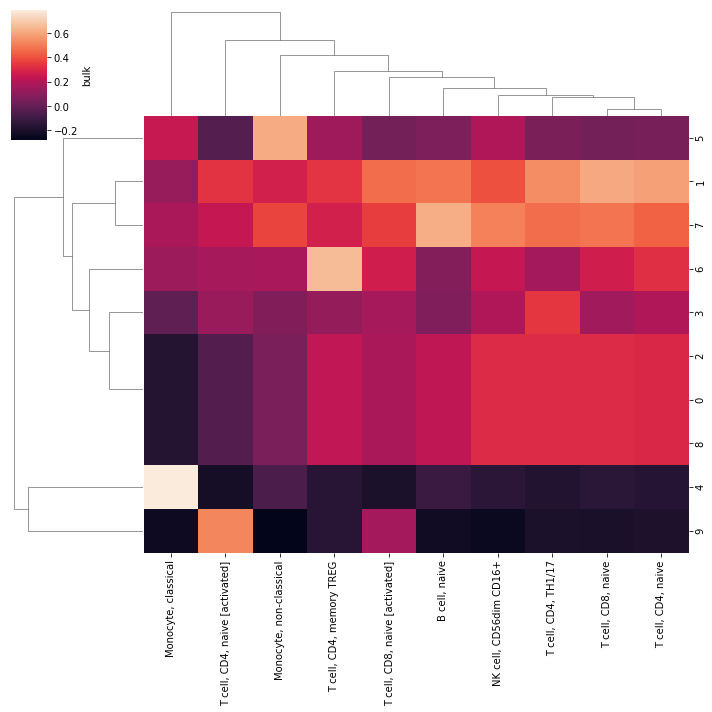

In [52]:
sel_top_genes = list(np.unique(topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)['Gene'].values))
K=10
corr=[]
for i in df_beta.index:
    cr = []
    for j in df_dice.index:
        cr.append(np.corrcoef(df_beta.loc[i,sel_top_genes],df_dice.loc[j,sel_top_genes])[0,1])
    corr.append(cr)

df_corr = pd.DataFrame(corr)
df_corr.index = df_beta.index
df_corr.columns = df_dice.index
sns.clustermap(df_corr)
plt.xlabel('sc')
plt.ylabel('bulk')

In [53]:
df_match = df_umap[['cell','cell_type','topic_bulk']]
df_match = df_match.groupby(['cell_type','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type','topic_bulk')
df_match = df_match.fillna(0)
df_match


cell                                       
topic_bulk                       1       4       5      6       7       9
cell_type                                                                
Bcell,naive                    0.0     0.0     0.0    0.0  1000.0     0.0
Monocyte,classical             0.0  1000.0     0.0    0.0     0.0     0.0
Monocyte,non-classical         0.0     0.0  1000.0    0.0     0.0     0.0
NKcell,CD56dimCD16+            0.0     0.0     0.0    0.0  1000.0     0.0
Tcell,CD4,TH1/17            1000.0     0.0     0.0    0.0     0.0     0.0
Tcell,CD4,memoryTREG          86.0     0.0     0.0  914.0     0.0     0.0
Tcell,CD4,naive             1000.0     0.0     0.0    0.0     0.0     0.0
Tcell,CD4,naive[activated]     0.0     0.0     0.0    0.0     0.0  1000.0
Tcell,CD8,naive             1000.0     0.0     0.0    0.0     0.0     0.0
Tcell,CD8,naive[activated]     0.0     0.0     0.0    0.0     0.0  1000.0

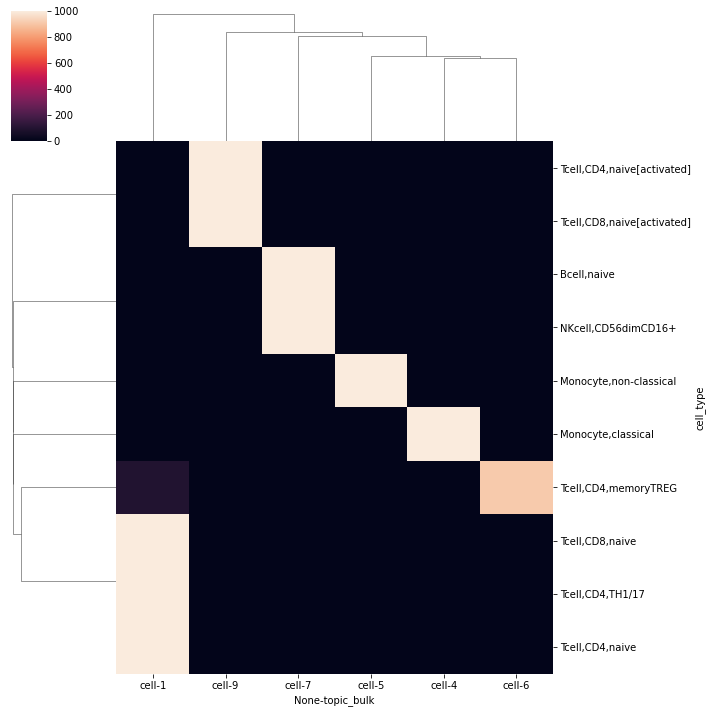

In [54]:
sns.clustermap(df_match)

In [55]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type'].values,df_umap['topic_bulk'].values)

0.8306502776587686